## 바이브코딩을 활용한 3차원 미사일 방어 시스템: 단계별 심화 문제

#### 상황: 
전면전 상황입니다. 적의 단일 발사 지점에서, 각기 다른 시간($t_{launch}$ )에 10발의 미사일이 도시 내 임의의 목표 지점을 향해 발사됩니다. 당신의 임무는 실시간으로 탐지되는 위협에 대해 두 기지가 유기적으로 협력하여 가장 효율적으로 방어 계획을 수립하고 실행하는 것입니다.

- 주어진 조건:
    - 요격 기지: $S_A=(50,20,0) $, $S_B=(−40,−30,0)$

- 요격 미사일 속력 : $v_I: 150 m/s$

- 요격 시간 계산식:
    - $∥P_{Hi}(t_{impact})−S∥=v_I⋅(t_{impact}−t_{launch_{i}} )$

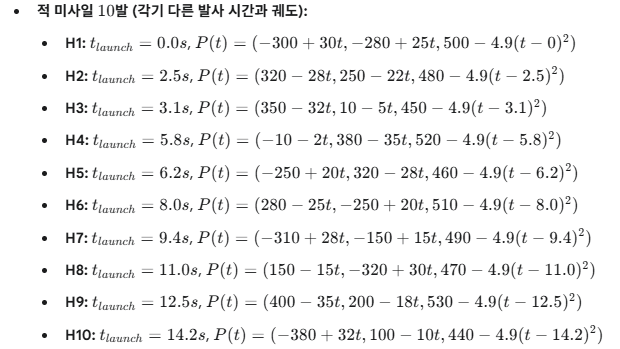

#### 도전 과제:
#### 1. 동적 최적 할당 알고리즘 구현:
- 10개의 모든 미사일에 대해, $t_{launch}$를 고려하여 '알파' 기지와 '브라보' 기지가 요격할 경우의 절대 요격 시간($t_{impact} $)을 각각 계산하세요.
- 각 미사일마다 더 빠른 절대 시간에 요격할 수 있는 기지에 임무를 할당하는 동적 방어 계획을 수립하세요.
#### 2. 실시간 방어 시뮬레이션:
- 시간의 흐름에 따라 방어 시스템이 작동하는 모습을 실시간으로 시뮬레이션하는 최종 애니메이션을 제작하세요.

C:\Users\brigh\AppData\Local\Temp\ipykernel_7688\2625850566.py:138: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  line, = ax.plot([],[],[],'r--', lw=1, color=colors[idx])


ValueError: quantization error

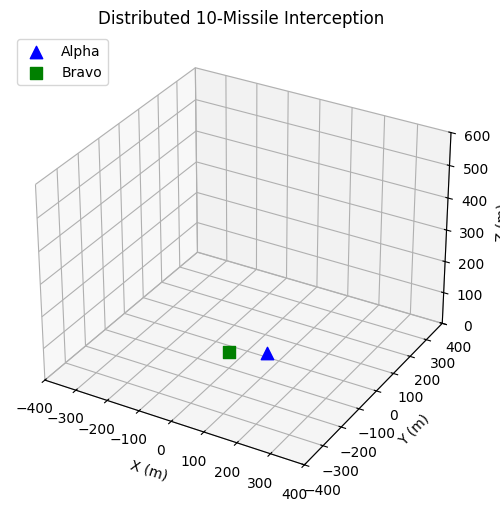

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.animation import PillowWriter

# 1. 방어 기지 & 요격 속력
S_A = np.array([50.0, 20.0, 0.0])     # Alpha 기지
S_B = np.array([-40.0, -30.0, 0.0])   # Bravo 기지
v_I = 150.0                           # 요격 미사일 속력 (m/s)

# 2. 발사 시점 및 궤적 정의
launch_times = [
    0.0, 2.5, 3.1, 5.8, 6.2,
    8.0, 9.4, 11.0, 12.5, 14.2
]

def make_P(H):
    t0, coeffs = launch_times[H-1], None
    if H == 1:
        def P(t): return np.stack([
            -300 + 30*(t - t0),
            -280 + 25*(t - t0),
             500 - 4.9*(t - t0)**2
        ], axis=-1)
    elif H == 2:
        def P(t): return np.stack([
            320 - 28*(t - t0),
            250 - 22*(t - t0),
            480 - 4.9*(t - t0)**2
        ], axis=-1)
    elif H == 3:
        def P(t): return np.stack([
            350 - 32*(t - t0),
             10 -  5*(t - t0),
            450 - 4.9*(t - t0)**2
        ], axis=-1)
    elif H == 4:
        def P(t): return np.stack([
            -10 -  2*(t - t0),
             380 - 35*(t - t0),
            520 - 4.9*(t - t0)**2
        ], axis=-1)
    elif H == 5:
        def P(t): return np.stack([
            -250 + 20*(t - t0),
             320 - 28*(t - t0),
            460 - 4.9*(t - t0)**2
        ], axis=-1)
    elif H == 6:
        def P(t): return np.stack([
             280 - 25*(t - t0),
            -250 + 20*(t - t0),
             510 - 4.9*(t - t0)**2
        ], axis=-1)
    elif H == 7:
        def P(t): return np.stack([
            -310 + 28*(t - t0),
            -150 + 15*(t - t0),
             490 - 4.9*(t - t0)**2
        ], axis=-1)
    elif H == 8:
        def P(t): return np.stack([
             150 - 15*(t - t0),
            -320 + 30*(t - t0),
             470 - 4.9*(t - t0)**2
        ], axis=-1)
    elif H == 9:
        def P(t): return np.stack([
             400 - 35*(t - t0),
             200 - 18*(t - t0),
             530 - 4.9*(t - t0)**2
        ], axis=-1)
    elif H == 10:
        def P(t): return np.stack([
            -380 + 32*(t - t0),
             100 - 10*(t - t0),
             440 - 4.9*(t - t0)**2
        ], axis=-1)
    return lambda t: np.where(t[:,None]>=t0, P(t), np.nan)

P_Hs = [make_P(i) for i in range(1, 11)]

# 3. 요격 시간 계산 (이분법 보간)
t = np.linspace(0, 30, 30001)  # 충분히 긴 시간 배열
def intercept_time(P_H, t_launch, S):
    idx = t >= t_launch + 1e-6
    tt = t[idx]
    pos = P_H(tt)
    dist = np.linalg.norm(pos - S, axis=1)
    f = dist - v_I*(tt - t_launch)
    sign = f[:-1]*f[1:] < 0
    crosses = np.where(sign)[0]
    if len(crosses)==0:
        return None
    i = crosses[0]
    t0, t1 = tt[i], tt[i+1]
    f0, f1 = f[i], f[i+1]
    return t0 - f0*(t1-t0)/(f1-f0)

# 4. 기지 할당 및 intercept 데이터 준비
assignments = []
for i, P_H in enumerate(P_Hs, start=1):
    t0 = launch_times[i-1]
    tA = intercept_time(P_H, t0, S_A)
    tB = intercept_time(P_H, t0, S_B)
    if tA is None and tB is None:
        base, t_imp, S = None, None, None
    elif tA is None or (tB is not None and tB < tA):
        base, t_imp, S = 'Bravo', tB, S_B
    else:
        base, t_imp, S = 'Alpha', tA, S_A
    P_imp = P_H(np.array([t_imp]))[0] if t_imp else None
    assignments.append({
        'P_H': P_H,
        't_launch': t0,
        'base': base,
        't_imp': t_imp,
        'S': S,
        'P_imp': P_imp
    })

# 5. 3D 애니메이션 & GIF 저장
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-400, 400); ax.set_ylim(-400, 400); ax.set_zlim(0, 600)
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
ax.set_title('Distributed 10-Missile Interception')

# 기지 표시
ax.scatter(*S_A, color='blue', marker='^', s=80, label='Alpha')
ax.scatter(*S_B, color='green', marker='s', s=80, label='Bravo')

# 객체 초기화
missile_lines, interceptor_lines, missile_dots = [], [], []
colors = plt.cm.tab10(np.linspace(0,1,10))
for idx, a in enumerate(assignments):
    line, = ax.plot([],[],[],'r--', lw=1, color=colors[idx])
    missile_lines.append(line)
    dot, = ax.plot([],[],[],'o', color=colors[idx], ms=4)
    missile_dots.append(dot)
    iline, = ax.plot([],[],[],
                     color='blue' if a['base']=='Alpha' else 'green',
                     lw=2)
    interceptor_lines.append(iline)

ax.legend(loc='upper left')

def init():
    for ln, dt, il in zip(missile_lines, missile_dots, interceptor_lines):
        ln.set_data([],[]); ln.set_3d_properties([])
        dt.set_data([],[]); dt.set_3d_properties([])
        il.set_data([],[]); il.set_3d_properties([])
    return missile_lines + missile_dots + interceptor_lines

def animate(k):
    tk = t[k]
    for i, a in enumerate(assignments):
        P_H, t0, base, t_imp, S, P_imp = (
            a['P_H'], a['t_launch'], a['base'],
            a['t_imp'], a['S'], a['P_imp']
        )
        path = P_H(t)
        # 궤적 선
        mask = (t>=t0) & (t<=min(t_imp or t[-1], t[k]))
        missile_lines[i].set_data(path[mask,0], path[mask,1])
        missile_lines[i].set_3d_properties(path[mask,2])
        # 미사일 현재 위치
        if tk >= t0 and tk <= (t_imp or t0):
            pos = P_H(np.array([tk]))[0]
            missile_dots[i].set_data([pos[0]],[pos[1]])
            missile_dots[i].set_3d_properties([pos[2]])
        # 요격선
        if t_imp and tk >= t_imp:
            interceptor_lines[i].set_data([S[0], P_imp[0]],
                                          [S[1], P_imp[1]])
            interceptor_lines[i].set_3d_properties([S[2], P_imp[2]])
    return missile_lines + missile_dots + interceptor_lines

ani = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=len(t), interval=30, blit=False
)

writer = PillowWriter(fps=25)
ani.save("intercept_10_missiles.gif", writer=writer)
print("intercept_10_missiles.gif 생성 완료")
